In [1]:
import autograd.numpy as np
import autograd.scipy as sp
import autograd
from autograd.core import primitive
import copy
import time

from collections import OrderedDict

from VariationalBayes import Parameters
from VariationalBayes import \
    ScalarParam, VectorParam, ArrayParam, \
    PosDefMatrixParam, PosDefMatrixParamVector, SimplexParam
from VariationalBayes.ParameterDictionary import ModelParamsDict
import scipy as osp
from scipy.sparse import csr_matrix
from scipy import sparse

In [13]:
k = 2

mat = np.full(k ** 2, 0.2).reshape(k, k) + np.eye(k)
vp_array = ArrayParam('array', shape=(4, 5, 7))
vp_mat = PosDefMatrixParam('mat', k, val=mat)
vp_simplex = SimplexParam('simplex', shape=(5, 3))


mp = ModelParamsDict()
mp.push_param(vp_mat)
mp.push_param(vp_simplex)
mp.push_param(vp_array)

def model(mp):
    mat = mp['mat'].get()
    array = mp['array'].get()
    simplex = mp['simplex'].get()
    
    return np.sum(mat)**2 * np.sum(array)**2 * np.sum(simplex)**2

def model_wrap_free(free_param, mp):
    mp.set_free(free_param)
    return model_wrap_vec(mp.get_vector(), mp)

def model_wrap_vec(vec_param, mp):
    mp.set_vector(vec_param)
    return model(mp)

free_vec = np.random.random(mp.free_size())
mp.set_free(free_vec)
mp_vec = mp.get_vector()

print(model_wrap_free(free_vec, mp))
print(model_wrap_vec(mp_vec, mp))

model_wrap_free_jac = autograd.jacobian(model_wrap_free)
model_wrap_vec_jac = autograd.jacobian(model_wrap_vec)
model_wrap_free_hess = autograd.hessian(model_wrap_free)
model_wrap_vec_hess = autograd.hessian(model_wrap_vec)

free_jac_target = model_wrap_free_jac(free_vec, mp)
vec_jac_target = model_wrap_vec_jac(mp_vec, mp)
free_hess_target = model_wrap_free_hess(free_vec, mp)
vec_hess_target = model_wrap_vec_hess(mp_vec, mp)



3547870.43599
3547870.43599


I think we need two steps.  Let $L$ be the objective and $f$ be the constraining function, so that 

$$
\theta = f(z) \\
L(\theta) = L(f(z))
$$

We need

$$
\frac{dL}{dz^T} = \frac{dL}{d\theta^T} \frac{d\theta}{dz} = \frac{dL}{d\theta^T} \frac{df}{dz^T}
$$

and, using Einstein summation notation,

$$
\frac{d^2 L}{dz_i dz_j} =
    \frac{d^2 L}{d\theta_a d\theta_b} \frac{d\theta_a}{dz_i} \frac{d\theta_b}{dz_j} +
    \frac{d L}{d\theta_a} \frac{d^2 \theta_a}{dz_i dz_j}
$$

The term $\frac{d^2 L}{d\theta_a d\theta_b}$ can be expressed using a combination of our ```get_vector()``` functions and a sparse matrix for the local variables.  $\frac{d\theta_a}{dz_i}$ can also be represented as a sparse matrix.  It may be best to store the term $\frac{d^2 \theta_a}{dz_i dz_j}$ in ```(value, a, i, j)``` format, and write a custom aggregator to return a sparse matrix when multiplied by $\frac{d L}{d\theta_a}$, since it is possible that this is not efficient in general [(discussion)](https://stackoverflow.com/questions/29871669/python-multi-dimensional-sparse-array).


In [29]:
print('free: ', len(free_vec))
print('vec: ', len(mp_vec))
print('free: ', free_hess_target.shape)
print('vec: ', vec_hess_target.shape)

def free_to_vec(free_vec, mp):
    mp.set_free(free_vec)
    return mp.get_vector()

# get_free_to_vec_jacobian = autograd.jacobian(free_to_vec)
# get_free_to_vec_hessian = autograd.hessian(free_to_vec)

'Calculating:'
free_to_vec_jacobian = mp.free_to_vector_jac(free_vec)
free_to_vec_hessian = mp.free_to_vector_hess(free_vec)
print(free_to_vec_jacobian.shape)
print(free_to_vec_hessian.shape)

free:  153
vec:  158
free:  (153, 153)
vec:  (158, 158)
(158, 153)
(158,)


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:16: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [37]:
free_hess = csr_matrix((mp.free_size(), mp.free_size()))
for vec_ind in range(mp.vector_size()):
    free_hess += free_to_vec_hessian[vec_ind] * vec_jac_target[vec_ind]
free_hess += \
    free_to_vec_jacobian.T * vec_hess_target * free_to_vec_jacobian

np.max(np.abs(free_hess - free_hess_target))

7.4505805969238281e-09

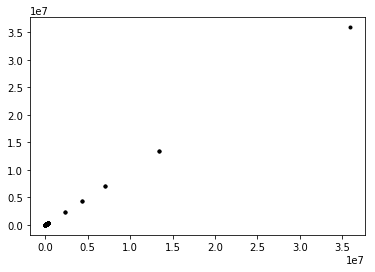

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(free_hess).flatten(), free_hess_target.flatten(), 'k.')